# calc RMSD 

In [3]:
%cd ~/desktop/RNA/casp16
import warnings
warnings.filterwarnings('ignore')
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd

casp_id = "M1293-complex"
pdb_dir=f"./datasets/casp16/{casp_id}/zdock/pdb"
# top_pdb_dir=f"./datasets/casp16/{casp_id}/zdock/top_pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


In [6]:
# !time python scripts/calc_rmsd.py --pdb_dir {top_pdb_dir} --cpu 8 --print_every 5
!time python scripts/calc_rmsd.py --pdb_dir {pdb_dir} --cpu 8 --print_every 5

['zdock.S_000001-top1.pdb', 'zdock.S_000002-top1.pdb', 'zdock.S_000003-top1.pdb', 'zdock.S_000004-top1.pdb', 'zdock.S_000005-top1.pdb']
Number of pdb files: 1000
Calculating RMSD matrix 1000x1000 using 8 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 65th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 35th pdb file
Calculating RMSD for 85th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 5th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 105th pdb file
Calculating RMSD for 55th pdb file
Calculating RMSD for 125th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 25th pdb file
Calculating RMSD for 75th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 130th pdb file
Calculating RMSD for 95th pdb file
Calculating RMSD 

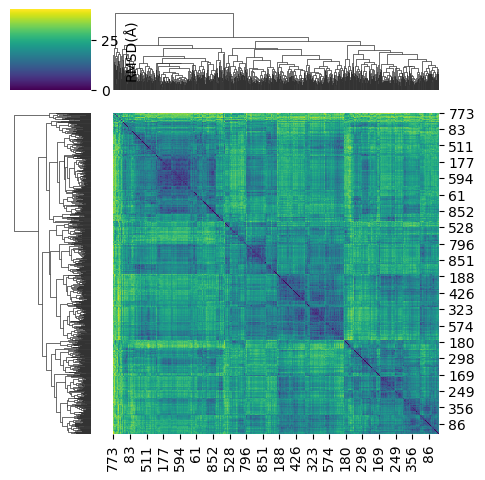

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
plt.tight_layout()
plt.savefig(f"{pdb_dir}/rmsd_clustermap.png", dpi = 300)

In [11]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
print(len(all_pdb_ids))
print(all_pdb_ids[:3])

1000
['S_000001', 'S_000002', 'S_000003']


In [12]:
df_rmsd = pd.DataFrame(rmsd, columns=all_pdb_ids, index=all_pdb_ids)
df_rmsd.to_csv(f"{pdb_dir}/rmsd_matrix_sorted_id.csv")

# clustering

In [13]:
import numpy as np
from sklearn.manifold import MDS

rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

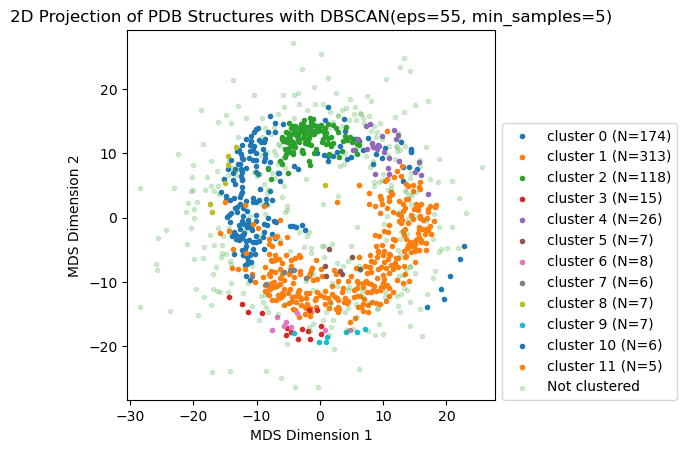

In [28]:
from sklearn.cluster import DBSCAN
eps =  55
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
plt.savefig(f"{pdb_dir}/rmsd_mds_dbscan_eps{eps}_min_samples{min_samples}.png", dpi=300)
plt.show()


In [30]:
import pandas as pd

df_scores = pd.read_csv(f"{pdb_dir}/M1293_scores.csv")
top_pdbs = !ls {pdb_dir}/*.pdb

eps = 55
top_pdbs = [os.path.basename(pdb).replace("-top1.pdb", "").replace("zdock.", "") for pdb in top_pdbs]
df_scores = df_scores[df_scores["pdb"].isin(top_pdbs)]
df_scores.head(2)

,pdb,BRiQscore,ZDOCKscore
0,S_000001,-109.946,3023.405
1,S_000002,-150.769,3127.552


In [31]:
df_scores["cluster"] = clustering.labels_
df_scores.to_csv(f"{pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv", index=False)
df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv")
df_scores.head(3)

,pdb,BRiQscore,ZDOCKscore,cluster
0,S_000001,-109.946,3023.405,0
1,S_000002,-150.769,3127.552,1
2,S_000003,-102.537,2971.157,3


In [32]:
pdb_list = []

print(" Sorted by BRiQscore")
print(df_scores.sort_values("BRiQscore").head(5))
pdb_list.extend(df_scores.sort_values("BRiQscore").head(5)["pdb"].values)
print(" Sorted by ZDOCKscore")
print(df_scores.sort_values("ZDOCKscore").tail(5))
pdb_list.extend(df_scores.sort_values("ZDOCKscore").tail(5)["pdb"].values)
print("**"*20)



 Sorted by BRiQscore
          pdb  BRiQscore  ZDOCKscore  cluster
462  S_000463   -206.310    3047.101       -1
744  S_000745   -196.116    3012.274        1
779  S_000780   -192.939    3705.625        2
29   S_000030   -191.578    2985.316       -1
447  S_000448   -190.701    3422.610        1
 Sorted by ZDOCKscore
          pdb  BRiQscore  ZDOCKscore  cluster
214  S_000215  -139.2460    3717.562        1
64   S_000065   -63.0474    3719.631        0
172  S_000173  -120.0850    3723.384        1
942  S_000943  -122.6880    3728.461        1
706  S_000707  -138.5830    3841.449        1
****************************************
